변수 계산 및 신규 데이터 저장 코드

In [4]:
import pandas as pd

# 파일 경로
file_general = "C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_컬럼제거.csv"
file_sales = "C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_매출추가_매출결측치_제거.csv"

# 데이터 로드
df_general = pd.read_csv(file_general)
df_sales = pd.read_csv(file_sales)

# 4개 분기(1년) 단위로 이동 표준 편차 및 증감률 계산
rolling_window = 4

# 유동인구 안정성
df_sales['유동인구_안정성'] = df_sales.groupby(['상권명', '업종명'])['유동인구수'].transform(lambda x: x.mean() / (x.std() + 1))

# 점포 수 변동성
df_general['점포_수_변동성'] = df_general.groupby(['상권명', '업종명'])['점포_수'].transform(lambda x: x.rolling(rolling_window).std())

# 점포 수 증감률
df_general['점포_수_증감률'] = df_general.groupby(['상권명', '업종명'])['점포_수'].transform(lambda x: x.pct_change(periods=rolling_window))

# 매출 관련 변수 생성
if '매출_금액' in df_sales.columns:
    df_sales['매출_변동성'] = df_sales.groupby(['상권명', '업종명'])['매출_금액'].transform(lambda x: x.rolling(rolling_window).std())
    df_sales['매출_증감률'] = df_sales.groupby(['상권명', '업종명'])['매출_금액'].transform(lambda x: x.pct_change(periods=rolling_window))
    df_sales['매출_안정성'] = df_sales.groupby(['상권명', '업종명'])['매출_금액'].transform(lambda x: x.median() / (x.std() + 1))
    df_sales['매출_감소율'] = df_sales.groupby(['상권명', '업종명'])['매출_금액'].transform(lambda x: (x.shift(rolling_window) - x) / (x.shift(rolling_window) + 1))
    df_sales['소비_전환율'] = df_sales['매출_금액'] / (df_sales['유동인구수'] + 1)

# 개폐업 관련 변수 생성
if '개업_점포_수' in df_general.columns and '폐업_점포_수' in df_general.columns:
    df_general['개폐업_비율'] = df_general['폐업_점포_수'] / (df_general['개업_점포_수'] + 1)
    df_general['개폐업_균형_지수'] = (df_general['개업_점포_수'] - df_general['폐업_점포_수']) / (df_general['개업_점포_수'] + df_general['폐업_점포_수'] + 1) * 100

# 프랜차이즈 관련 변수 생성
if '프랜차이즈_점포_수' in df_general.columns and '점포_수' in df_general.columns:
    df_general['프랜차이즈_비율'] = df_general['프랜차이즈_점포_수'] / df_general['점포_수']
    df_general['프랜차이즈_변동성'] = df_general.groupby(['상권명', '업종명'])['프랜차이즈_점포_수'].transform(lambda x: x.rolling(rolling_window).std())

# 영업 개월 차이
df_general['영업_개월_차이'] = df_general.groupby(['상권명', '업종명']).apply(lambda x: x['서울_운영_영업_개월_평균'].rolling(rolling_window).mean() - x['서울_폐업_영업_개월_평균'].rolling(rolling_window).mean()).reset_index(level=[0,1], drop=True)

# 점포 생존율
if '점포_수' in df_general.columns and '폐업_점포_수' in df_general.columns:
    df_general['점포_생존율'] = 1 - (df_general['폐업_점포_수'] / df_general['점포_수'])

# 유사업종 경쟁 강도
if '유사_업종_점포_수' in df_general.columns and '점포_수' in df_general.columns:
    df_general['유사_업종_경쟁_강도'] = df_general['유사_업종_점포_수'] / df_general['점포_수']

df_general["점포_증감률"] = df_general.groupby(["상권명", "업종명"])["점포_수"].transform(lambda x: (x - x.shift(1)) / (x.shift(1) + 1) * 100)

# 데이터 저장
df_general.to_csv("C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_일반변수.csv", index=False)
df_sales.to_csv("C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_매출변수.csv", index=False)

print("변수 생성 완료: 일반 변수(df_general)와 매출 변수(df_sales) 각각 저장됨.")

C:\Users\m\AppData\Local\Temp\ipykernel_3212\796764776.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_general['영업_개월_차이'] = df_general.groupby(['상권명', '업종명']).apply(lambda x: x['서울_운영_영업_개월_평균'].rolling(rolling_window).mean() - x['서울_폐업_영업_개월_평균'].rolling(rolling_window).mean()).reset_index(level=[0,1], drop=True)


변수 생성 완료: 일반 변수(df_general)와 매출 변수(df_sales) 각각 저장됨.


1️⃣ 📂 서울시_상권분석_서비스_매출추가_결과.csv
(매출 데이터를 포함한 파일 → df_sales)

- 매출 변동성

4개 분기 매출의 표준편차

- 매출 증감률

(현재 분기의 매출 - 4개 분기 전의 매출) / 4개 분기 전의 매출

* 매출 안정성 (매출_안정성)

매출 금액의 중위값을 표준편차로 나눈 값으로, 매출 변동성을 고려한 안정성 지표.
계산식: 매출_금액의 중위값 / (표준편차 + 1)


- 매출 감소율 (매출_감소율)

이전 분기 대비 현재 분기의 매출 감소 비율을 나타냄.
계산식: (이전 분기 매출 - 현재 분기 매출) / (이전 분기 매출 + 1)
groupby(['상권명', '업종명'])을 이용해 분기별로 변화량 계산.

* 소비 전환율 (소비_전환율)

유동인구 대비 실제 매출이 발생하는 비율을 나타냄.
계산식: 매출_금액 / (유동인구수 + 1)

* 유동인구 안정성 (유동인구_안정성)

유동인구의 평균값을 표준편차로 나눈 값으로, 유동인구 변동성을 고려한 안정성 지표.
계산식: 유동인구수의 평균 / (표준편차 + 1)

2️⃣ 📂 서울시_상권분석_서비스_컬럼제거_결과.csv
(일반적인 상권 데이터 → df_general)

추가된 변수

- 점포 수 변동성 (점포_수_변동성)

각 상권의 점포 수 변동성을 반영하기 위해 이전 분기 대비 표준편차를 계산.
계산식: 점포_수의 rolling std()

* 개폐업 비율 (개폐업_비율)

폐업 점포 수를 개업 점포 수로 나눈 값으로, 상권 내 점포 변화 정도를 평가.
계산식: 폐업_점포_수 / (개업_점포_수 + 1)

* 개폐업 균형 지수 (개폐업_균형_지수)

개업과 폐업 간의 균형을 측정하는 지표.
계산식: (개업_점포_수 - 폐업_점포_수) / (개업_점포_수 + 폐업_점포_수 + 1) * 100
양수면 개업이 많고, 음수면 폐업이 많음을 의미.

- 프랜차이즈 비율 (프랜차이즈_비율)

전체 점포 중 프랜차이즈 점포가 차지하는 비율을 나타냄.
계산식: 프랜차이즈_점포_수 / 점포_수

- 프랜차이즈 변동성 (프랜차이즈_변동성)

프랜차이즈 점포 수의 변동성을 평가하기 위해 rolling std() 계산.
계산식: 프랜차이즈_점포_수의 rolling std()

* 영업 개월 차이 (영업_개월_차이)

운영 중인 점포의 평균 영업 개월 수와 폐업한 점포의 평균 영업 개월 수 차이.
계산식: 영업_개월_평균 - 폐업_영업_개월_평균
값이 크면 기존 점포들이 오래 운영되었다는 의미.

* 점포 증감률 (점포_증감률)

이전 분기 대비 점포 수 증가율을 나타냄.
계산식: (점포_수 - 이전 분기 점포 수) / 이전 분기 점포 수 * 100
값이 크면 점포가 많이 늘어나고 있다는 의미.

* 점포 생존율 (점포_생존율)

폐업 점포 수를 고려한 전체 점포 생존 비율.
계산식: 1 - (폐업_점포_수 / 점포_수)
1에 가까울수록 점포가 유지되는 비율이 높음.

* 유사업종 경쟁 강도 (유사업종_경쟁_강도)

특정 상권 내 같은 업종의 점포 비율을 나타냄.
계산식: 유사 업종 점포 수 / 점포 수
값이 높을수록 특정 업종에 대한 경쟁이 치열함을 의미.

매출 변수 파일 확인 결과 : 매출 변동성, 매출 증감률, 매출 감소율열에서 간혹 null값이 발견됨. 분석시 null값을 제외하고 분석하도록 해야 할듯. 매출 증감률, 매출 감소율열 20223, 20193분기에서 null 자주 발생. 매출 변동성열 20192분기까지 null.

일반 변수 파일 확인 결과 : 점포 수 변동성, 프랜차이즈 변동성 열에서 20192분기까지 null. 점포 수 증감률 열에서 20193분기까지 null 다수. 프랜차이즈 비율 열에서 일부 값 inf로 출력됨.

상관계수 분석

In [ ]:
import pandas as pd

# 파일 경로
file_general = "C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_일반변수.csv"
file_sales = "C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_매출변수.csv"

# 데이터 로드
df_general = pd.read_csv(file_general)
df_sales = pd.read_csv(file_sales)

# 필요한 컬럼만 선택
selected_columns = [
    "매출_안정성", "소비_전환율", "유동인구_안정성",
    "개폐업_비율", "개폐업_균형_지수", "영업_개월_차이",
    "점포_증감률", "점포_생존율", "유사_
    업종_경쟁_강도"
]

# 데이터 병합 (공통된 키: 연분기, 상권명, 업종명)
df_merged = pd.merge(df_general, df_sales, on=["연분기", "상권명", "업종명"], how="inner")

# 선택한 컬럼만 필터링
df_selected = df_merged[selected_columns]

# 상관계수 계산
correlation_matrix = df_selected.corr()

# 상관계수 출력
print(correlation_matrix)

               매출_안정성    소비_전환율  유동인구_안정성    개폐업_비율  개폐업_균형_지수  영업_개월_차이  \
매출_안정성       1.000000  0.001468  0.001371 -0.005634   0.000500  0.003422   
소비_전환율       0.001468  1.000000 -0.001270 -0.001090  -0.000338  0.003432   
유동인구_안정성     0.001371 -0.001270  1.000000  0.002101   0.013247  0.021076   
개폐업_비율      -0.005634 -0.001090  0.002101  1.000000  -0.583075  0.017894   
개폐업_균형_지수    0.000500 -0.000338  0.013247 -0.583075   1.000000 -0.027094   
영업_개월_차이     0.003422  0.003432  0.021076  0.017894  -0.027094  1.000000   
점포_증감률       0.001052 -0.000518  0.024857 -0.116838   0.284213  0.009570   
점포_생존율       0.004716  0.000936 -0.000786 -0.414619   0.374895 -0.000105   
유사_업종_경쟁_강도 -0.002086 -0.000581  0.003802  0.017075  -0.002430 -0.006245   

               점포_증감률    점포_생존율  유사_업종_경쟁_강도  
매출_안정성       0.001052  0.004716    -0.002086  
소비_전환율      -0.000518  0.000936    -0.000581  
유동인구_안정성     0.024857 -0.000786     0.003802  
개폐업_비율      -0.116838 -0.414619     0.017075  
개폐업_

In [14]:
import pandas as pd

# 데이터 불러오기
file_general = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
file_sales = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수.csv"

df_general = pd.read_csv(file_general, encoding="utf-8")
df_sales = pd.read_csv(file_sales, encoding="utf-8")

# 병합 (중복 컬럼 제거)
df = pd.merge(df_general, df_sales, on=["연분기", "상권명", "업종명"], how="inner")

# _x, _y로 중복된 컬럼 처리 (일반적으로 동일한 데이터이므로 하나만 유지)
for col in df.columns:
    if col.endswith("_x"):  # "_x"가 붙은 컬럼만 확인
        base_col = col[:-2]  # "_x" 제거
        if base_col + "_y" in df.columns:  # 동일한 _y 컬럼이 있으면 삭제
            df.drop(columns=[base_col + "_y"], inplace=True)
        df.rename(columns={col: base_col}, inplace=True)  # _x를 원래 이름으로 변경

# 컬럼명 확인
print(df.columns)

Index(['연분기', '상권명', '업종명', '점포_수', '유사_업종_점포_수', '개업율', '개업_점포_수', '폐업률',
       '폐업_점포_수', '프랜차이즈_점포_수', '자치구명', '서울_운영_영업_개월_평균', '서울_폐업_영업_개월_평균',
       '점포_수_변동성', '점포_수_증감률', '개폐업_비율', '개폐업_균형_지수', '프랜차이즈_비율', '프랜차이즈_변동성',
       '영업_개월_차이', '점포_생존율', '유사_업종_경쟁_강도', '점포_증감률', '매출_금액', '매출_건수',
       '유동인구수', '유동인구_안정성', '매출_변동성', '매출_증감률', '매출_안정성', '매출_감소율', '소비_전환율'],
      dtype='object')


c:\Users\m\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


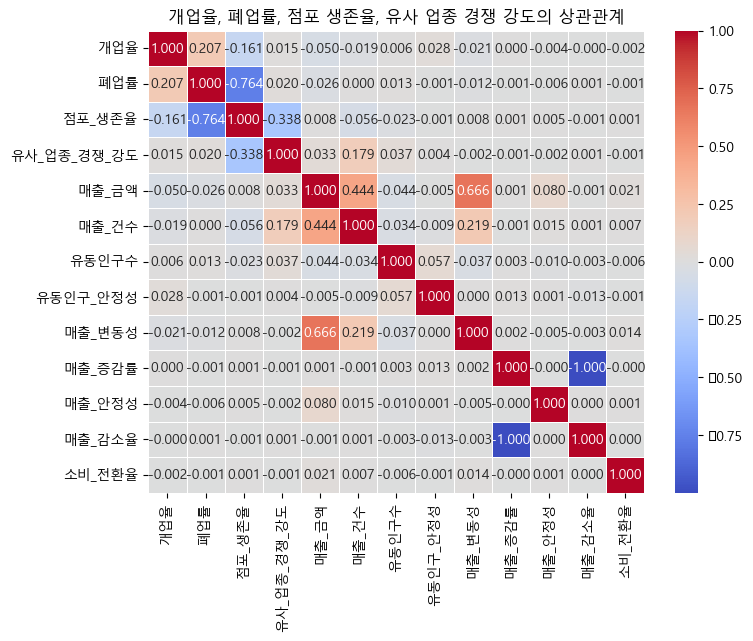

In [18]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rc("font", family="Malgun Gothic")

# 사용할 변수 선택
selected_cols = [
    "개업율", "폐업률", "점포_생존율", "유사_업종_경쟁_강도", "매출_금액", "매출_건수", "유동인구수", "유동인구_안정성", "매출_변동성", "매출_증감률", "매출_안정성", "매출_감소율", "소비_전환율"
]
df_selected = df[selected_cols]

# 상관관계 계산
corr_matrix = df_selected.corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("개업율, 폐업률, 점포 생존율, 유사 업종 경쟁 강도의 상관관계")
plt.show()

# 안전성 지표 개발 - 김민규 담당

## Step1. 안전성 라벨링 부여를 위한 기준 잡기 

In [ ]:
# 점포 생존율 컬럼 평균, 최빈값, 중앙값 확인

import pandas as pd
import numpy as np
from scipy import stats

# CSV 파일 불러오기
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
df = pd.read_csv(file_path)

# "점포_생존율" 컬럼 값 확인
print("점포_생존율 컬럼의 고유 값들:")
print(df["점포_생존율"].unique())

# 결측치 및 무한대 값 처리
df_filtered = df["점포_생존율"].replace([np.inf, -np.inf], np.nan).dropna()

# 평균, 중앙값 계산
mean_value = df_filtered.mean()
median_value = df_filtered.median()

# 최빈값 계산 (단일 값이 아닐 수도 있으므로 대응)
mode_result = stats.mode(df_filtered, keepdims=True)
mode_value = mode_result.mode[0] if mode_result.mode.size > 0 else None

print(f"\n점포_생존율 평균: {mean_value}")
print(f"점포_생존율 중앙값: {median_value}")
print(f"점포_생존율 최빈값: {mode_value if mode_value is not None else '최빈값 없음'}")

점포_생존율 컬럼의 고유 값들:
[1.               -inf 0.9        ... 0.9813846  0.98034398 0.99774266]

점포_생존율 평균: 0.9739928132103385
점포_생존율 중앙값: 1.0
점포_생존율 최빈값: 1.0


### 안정성 라벨링 하기

In [21]:
import pandas as pd
import numpy as np

# CSV 파일 불러오기
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
df = pd.read_csv(file_path)

# 점포_생존율의 평균값 계산 (무한대 및 결측치 제외)
df_filtered = df["점포_생존율"].replace([np.inf, -np.inf], np.nan)
mean_value = df_filtered.mean()

# "안정성" 컬럼 추가 (평균 이상이면 "안정", 평균 미만이면 "불안정", 결측치는 "NULL")
df["안정성"] = df_filtered.apply(lambda x: "안정" if x >= mean_value else ("불안정" if pd.notna(x) else "NULL"))

# 새로운 파일로 저장
output_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"파일 저장 완료: {output_path}")

파일 저장 완료: C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv


In [23]:
import pandas as pd
import numpy as np

# CSV 파일 불러오기
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수.csv"
df = pd.read_csv(file_path)

# 점포_생존율 계산 (1 - 폐업_점포_수 / 점포_수)
df["점포_생존율"] = 1 - (df["폐업_점포_수"] / df["점포_수"])

# inf, -inf 값 제거 및 NaN 변환
df["점포_생존율"].replace([np.inf, -np.inf], np.nan, inplace=True)

# 점포_생존율의 평균값 계산
mean_value = df["점포_생존율"].mean()

# "안정성" 컬럼 추가 (평균 이상이면 "안정", 평균 미만이면 "불안정", 결측치는 "NULL")
df["안정성"] = df["점포_생존율"].apply(lambda x: "안정" if x >= mean_value else ("불안정" if pd.notna(x) else "NULL"))

# 새로운 파일로 저장
output_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"파일 저장 완료: {output_path}")

C:\Users\m\AppData\Local\Temp\ipykernel_3212\915862682.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["점포_생존율"].replace([np.inf, -np.inf], np.nan, inplace=True)


파일 저장 완료: C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv


두 데이터의 평균의 차이 확인. 다시 라벨링. 비율 확인 결과 최빈값, 중앙값인 1로 설정.

In [24]:
import pandas as pd
import numpy as np
from scipy import stats

# 파일 경로
file_path_sales = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수.csv"
file_path_general = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"

# 파일 불러오기
df_sales = pd.read_csv(file_path_sales)
df_general = pd.read_csv(file_path_general)

# 매출 변수 파일의 점포_생존율 계산 (1 - (폐업_점포_수 / 점포_수))
df_sales["점포_생존율"] = 1 - (df_sales["폐업_점포_수"] / df_sales["점포_수"])

# inf, -inf, NaN 값 제거
df_sales["점포_생존율"].replace([np.inf, -np.inf], np.nan, inplace=True)
df_general["점포_생존율"].replace([np.inf, -np.inf], np.nan, inplace=True)

# 유효한 값만 필터링 (결측치 제거)
df_sales_filtered = df_sales["점포_생존율"].dropna()
df_general_filtered = df_general["점포_생존율"].dropna()

# 평균, 중앙값, 최빈값 계산 함수
def calculate_stats(series):
    mean_value = series.mean()
    median_value = series.median()
    mode_value = stats.mode(series, keepdims=True)[0][0]  # 최빈값
    return mean_value, median_value, mode_value

# 매출 변수 파일의 점포_생존율 통계
mean_sales, median_sales, mode_sales = calculate_stats(df_sales_filtered)

# 일반 변수 파일의 점포_생존율 통계
mean_general, median_general, mode_general = calculate_stats(df_general_filtered)

# 결과 출력
print("📌 매출 변수 파일의 점포_생존율")
print(f"- 평균: {mean_sales}")
print(f"- 중앙값: {median_sales}")
print(f"- 최빈값: {mode_sales}\n")

print("📌 일반 변수 파일의 점포_생존율")
print(f"- 평균: {mean_general}")
print(f"- 중앙값: {median_general}")
print(f"- 최빈값: {mode_general}")

📌 매출 변수 파일의 점포_생존율
- 평균: 0.9635622948021249
- 중앙값: 1.0
- 최빈값: 1.0

📌 일반 변수 파일의 점포_생존율
- 평균: 0.9739928132103385
- 중앙값: 1.0
- 최빈값: 1.0


C:\Users\m\AppData\Local\Temp\ipykernel_3212\3264130912.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sales["점포_생존율"].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\m\AppData\Local\Temp\ipykernel_3212\3264130912.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [31]:
import pandas as pd
import numpy as np

# 파일 불러오기
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수.csv"
df_sales = pd.read_csv(file_path)

# 점포_생존율 계산 (0으로 나누는 경우 대비)
df_sales["점포_생존율"] = 1 - (df_sales["폐업_점포_수"] / df_sales["점포_수"]).replace([np.inf, -np.inf], np.nan)

# 기준 평균값 (매출 변수 파일 기준)
threshold = 1

# 안정성 컬럼 생성
df_sales["안정성"] = np.where(df_sales["점포_생존율"] >= threshold, "안정", "불안정")
df_sales.loc[df_sales["점포_생존율"].isna(), "안정성"] = "NULL"  # 결측치는 NULL로 표시

# 새로운 파일로 저장
output_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv"
df_sales.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"파일 저장 완료: {output_path}")

파일 저장 완료: C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv


In [32]:
import pandas as pd
import numpy as np

# 파일 불러오기
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
df_general = pd.read_csv(file_path)

# 점포_생존율 컬럼의 inf, -inf를 NaN으로 변환
df_general["점포_생존율"] = df_general["점포_생존율"].replace([np.inf, -np.inf], np.nan)

# 기준 평균값 (매출 변수 파일 기준)
threshold = 1

# 안정성 컬럼 생성
df_general["안정성"] = np.where(df_general["점포_생존율"] >= threshold, "안정", "불안정")
df_general.loc[df_general["점포_생존율"].isna(), "안정성"] = "NULL"  # 결측치는 NULL로 표시

# 새로운 파일로 저장
output_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv"
df_general.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"파일 저장 완료: {output_path}")

파일 저장 완료: C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv


라벨링 비율 확인

In [33]:
# 파일 경로 설정
file_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv"
}

# 각 파일에서 안정성 컬럼 비율 계산
for file_name, path in file_paths.items():
    # 파일 불러오기
    df = pd.read_csv(path)

    # 안정성 컬럼의 비율 계산
    stability_ratio = df["안정성"].value_counts(normalize=True) * 100  # 백분율 변환

    # 출력
    print(f"\n✅ {file_name} 안정성 비율:")
    print(stability_ratio.round(1).astype(str) + "%")  # 소수점 1자리까지 표시


✅ 매출 변수 파일 안정성 비율:
안정성
안정     76.8%
불안정    23.2%
Name: proportion, dtype: object

✅ 일반 변수 파일 안정성 비율:
안정성
안정     90.1%
불안정     9.9%
Name: proportion, dtype: object


상위 0.1퍼센트 값 확인

In [38]:
# 각 파일에서 상위 20% 점포 생존율 값 계산
for file_name, path in file_paths.items():
    # 파일 불러오기
    df = pd.read_csv(path)

    # 점포_생존율 컬럼이 존재하는지 확인 후 처리
    if "점포_생존율" not in df.columns:
        print(f"⚠ {file_name}에 '점포_생존율' 컬럼이 없음.")
        continue

    # 점포_생존율 컬럼에서 inf 및 NaN 값 제거
    df_filtered = df["점포_생존율"].replace([np.inf, -np.inf], np.nan).dropna()

    # 상위 20% (80번째 백분위수) 값 계산
    top_20_percentile = df_filtered.quantile(0.999)

    # 출력
    print(f"✅ {file_name} 점포 생존율 상위 20% 값: {top_20_percentile:.6f}")


✅ 매출 변수 파일 점포 생존율 상위 20% 값: 1.000000
✅ 일반 변수 파일 점포 생존율 상위 20% 값: 1.000000


상위 데이터 출력

In [40]:
# 파일 경로 설정
file_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv"
}

# 상위 몇 개 데이터를 출력할지 설정
top_n = 20  # 예: 상위 20개 데이터 출력

for file_name, path in file_paths.items():
    # 파일 불러오기
    df = pd.read_csv(path)

    # 점포_생존율 컬럼 확인 후 처리
    if "점포_생존율" not in df.columns:
        print(f"⚠ {file_name}에 '점포_생존율' 컬럼이 없음.")
        continue

    # 점포_생존율 컬럼에서 inf 및 NaN 값 제거
    df_filtered = df["점포_생존율"].replace([np.inf, -np.inf], np.nan).dropna()

    # 내림차순 정렬 후 상위 N개 데이터 출력
    top_values = df_filtered.sort_values(ascending=False).head(top_n)

    # 출력
    print(f"\n✅ {file_name} 상위 {top_n}개 점포 생존율 값:")
    print(top_values.to_string(index=False))


✅ 매출 변수 파일 상위 20개 점포 생존율 값:
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

✅ 일반 변수 파일 상위 20개 점포 생존율 값:
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


폐업률 컬럼 분포 확인


✅ 매출 변수 파일 폐업률 통계값
- 최솟값: 0
- 최댓값: 133
- 평균값: 2.7262164988711395
- 중앙값: 0.0
- 최빈값: 0


c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54224 (\N{HANGUL SYLLABLE PYE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\I

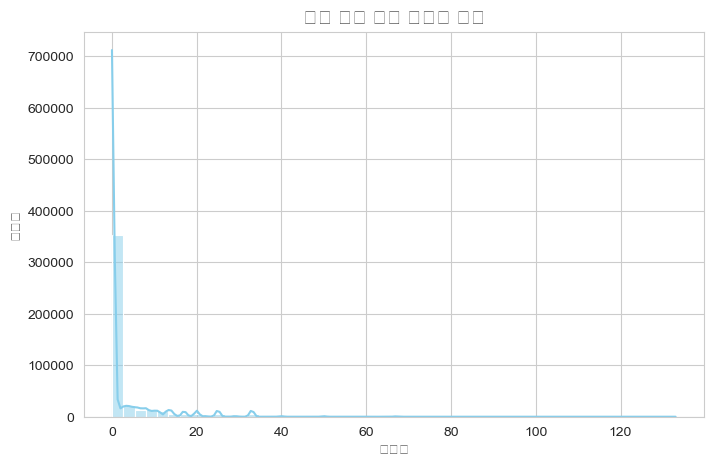


✅ 일반 변수 파일 폐업률 통계값
- 최솟값: 0
- 최댓값: 4800
- 평균값: 2.305900340329155
- 중앙값: 0.0
- 최빈값: 0


c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54224 (\N{HANGUL SYLLABLE PYE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\I

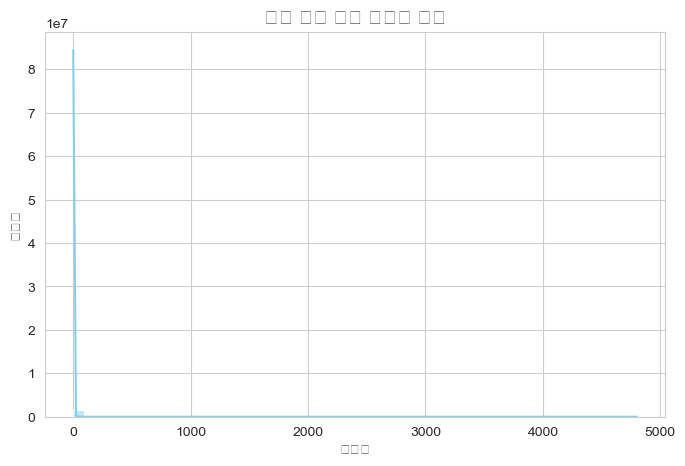

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (그래프 깨짐 방지)
plt.rc("font", family="Malgun Gothic")

# 파일 경로 설정
file_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
}

# 그래프 스타일 설정
sns.set_style("whitegrid")

# 폐업률 분포 확인
for file_name, path in file_paths.items():
    # 파일 불러오기
    df = pd.read_csv(path)

    # 폐업률 컬럼 확인
    if "폐업률" not in df.columns:
        print(f"⚠ {file_name}에 '폐업률' 컬럼이 없음.")
        continue

    # 폐업률 데이터 필터링 (inf, -inf, NaN 제거)
    df_filtered = df["폐업률"].replace([np.inf, -np.inf], np.nan).dropna()

    # 기초 통계값 계산
    min_value = df_filtered.min()
    max_value = df_filtered.max()
    mean_value = df_filtered.mean()
    median_value = df_filtered.median()

    # 최빈값 계산 (오류 방지)
    mode_values = df_filtered.mode()
    mode_value = mode_values.iloc[0] if not mode_values.empty else None

    # 결과 출력
    print(f"\n✅ {file_name} 폐업률 통계값")
    print(f"- 최솟값: {min_value}")
    print(f"- 최댓값: {max_value}")
    print(f"- 평균값: {mean_value}")
    print(f"- 중앙값: {median_value}")
    print(f"- 최빈값: {mode_value}")

    # 히스토그램 시각화
    plt.figure(figsize=(8, 5))
    sns.histplot(df_filtered, bins=50, kde=True, color="skyblue")
    plt.title(f"{file_name} 폐업률 분포", fontsize=14)
    plt.xlabel("폐업률")
    plt.ylabel("빈도수")
    plt.show()

폐업률 기준으로 안정성 컬럼 생성

In [45]:
# 파일 경로 설정
file_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
}

# 저장 경로 (새 파일로 저장)
output_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv"
}

# 폐업률 기준
threshold = 2.305900340329155

for file_name, path in file_paths.items():
    # 파일 불러오기
    df = pd.read_csv(path)

    # 폐업률 컬럼 확인
    if "폐업률" not in df.columns:
        print(f"⚠ {file_name}에 '폐업률' 컬럼이 없음.")
        continue

    # 안정성 컬럼 생성
    df["안정성"] = np.where(df["폐업률"] > threshold, "불안정", "안정")
    
    # 결측치 처리 (inf, -inf, NaN → NULL)
    df.loc[df["폐업률"].replace([np.inf, -np.inf], np.nan).isna(), "안정성"] = "NULL"

    # 파일 저장
    df.to_csv(output_paths[file_name], index=False, encoding="utf-8-sig")

    print(f"✅ {file_name} 안정성 컬럼 추가 완료! 저장됨 → {output_paths[file_name]}")

✅ 매출 변수 파일 안정성 컬럼 추가 완료! 저장됨 → C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv
✅ 일반 변수 파일 안정성 컬럼 추가 완료! 저장됨 → C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv


In [46]:
# 파일 경로 설정
file_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_안정성추가.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_안정성추가.csv"
}

# 각 파일에서 안정성 컬럼 비율 계산
for file_name, path in file_paths.items():
    # 파일 불러오기
    df = pd.read_csv(path)

    # 안정성 컬럼의 비율 계산
    stability_ratio = df["안정성"].value_counts(normalize=True) * 100  # 백분율 변환

    # 출력
    print(f"\n✅ {file_name} 안정성 비율:")
    print(stability_ratio.round(1).astype(str) + "%")  # 소수점 1자리까지 표시


✅ 매출 변수 파일 안정성 비율:
안정성
안정     79.0%
불안정    21.0%
Name: proportion, dtype: object

✅ 일반 변수 파일 안정성 비율:
안정성
안정     90.9%
불안정     9.1%
Name: proportion, dtype: object


In [47]:
import pandas as pd

# 파일 로드
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
df = pd.read_csv(file_path)

# 결측치 및 비정상값 제거
df_filtered = df["폐업률"].replace([float("inf"), float("-inf")], pd.NA).dropna()

# 75번째 백분위수 값 계산 (상위 25% 기준)
threshold_75 = df_filtered.quantile(0.75)

print(f"✅ 폐업률 상위 25% 기준값: {threshold_75}")

✅ 폐업률 상위 25% 기준값: 0.0


폐업-개업 비율 컬럼 생성

In [48]:
import pandas as pd

def add_closure_opening_ratio(file_path, save_path):
    # 파일 불러오기
    df = pd.read_csv(file_path)

    # 결측치 및 무한대 값 처리
    df.replace([float("inf"), float("-inf")], pd.NA, inplace=True)

    # 개업 점포 수와 폐업 점포 수 컬럼 확인 후 존재하면 계산
    if "개업_점포_수" in df.columns and "폐업_점포_수" in df.columns:
        df["폐업-개업 비율"] = df["폐업_점포_수"] / (df["개업_점포_수"] + 1)  # 개업 점포가 0이면 +1로 방지
    else:
        print("❌ 개업_점포_수 또는 폐업_점포_수 컬럼이 없습니다.")
        return

    # 새로운 컬럼 추가된 데이터 저장
    df.to_csv(save_path, index=False)
    print(f"✅ 새로운 비율 컬럼 추가 완료! 파일 저장: {save_path}")

# 📂 적용할 파일 경로
file_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
}

# 📂 저장할 파일 경로
save_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_비율추가.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_비율추가.csv"
}

# 두 파일 모두 적용
for key in file_paths:
    add_closure_opening_ratio(file_paths[key], save_paths[key])

✅ 새로운 비율 컬럼 추가 완료! 파일 저장: C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_비율추가.csv
✅ 새로운 비율 컬럼 추가 완료! 파일 저장: C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_비율추가.csv



✅ 매출 변수 파일 폐업-개업 비율 통계값
count    445582.000000
mean          0.226238
std           0.605432
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          71.000000
Name: 폐업-개업 비율, dtype: float64


c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54224 (\N{HANGUL SYLLABLE PYE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IP

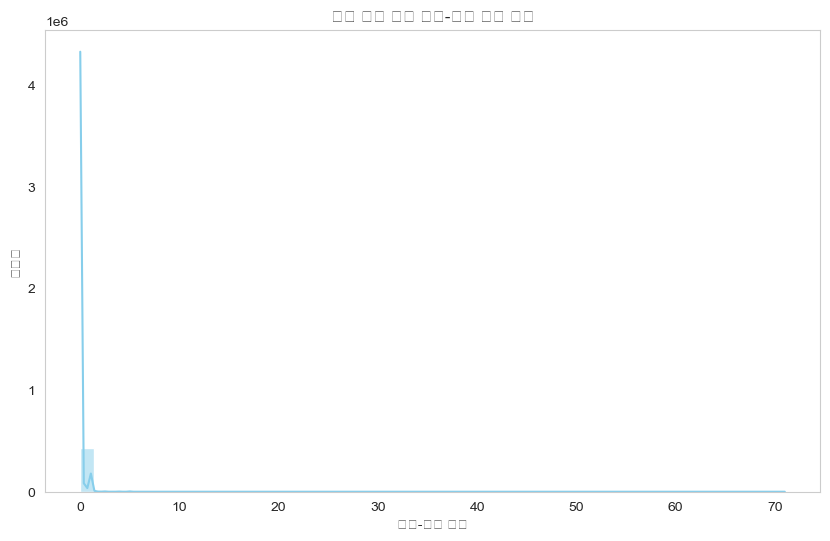


✅ 일반 변수 파일 폐업-개업 비율 통계값
count    1.664565e+06
mean     1.045104e-01
std      4.054909e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.100000e+01
Name: 폐업-개업 비율, dtype: float64


c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54224 (\N{HANGUL SYLLABLE PYE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IP

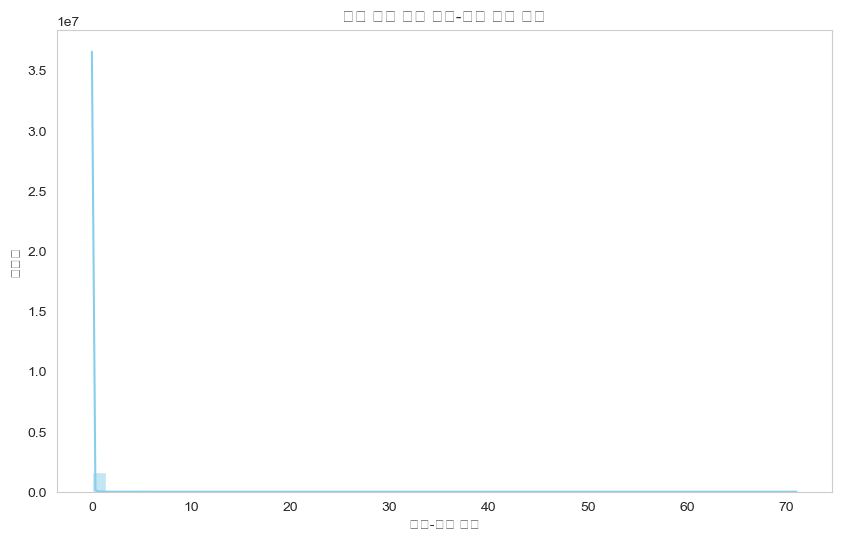

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_closure_opening_ratio(file_path, file_name):
    # 파일 불러오기
    df = pd.read_csv(file_path)

    # "폐업-개업 비율" 컬럼 확인
    if "폐업-개업 비율" not in df.columns:
        print(f"❌ {file_name} 파일에 '폐업-개업 비율' 컬럼이 없습니다.")
        return

    # 결측치 및 이상치 제거
    df_filtered = df["폐업-개업 비율"].dropna()
    df_filtered = df_filtered[df_filtered != float("inf")]  # 무한대 값 제거

    if df_filtered.empty:
        print(f"⚠️ {file_name} 파일에 유효한 데이터가 없습니다.")
        return

    # 📊 통계값 출력
    desc = df_filtered.describe(percentiles=[0.25, 0.5, 0.75])
    print(f"\n✅ {file_name} 폐업-개업 비율 통계값")
    print(desc)

    # 📈 히스토그램 플롯
    plt.figure(figsize=(10, 6))
    sns.histplot(df_filtered, bins=50, kde=True, color="skyblue")
    plt.xlabel("폐업-개업 비율")
    plt.ylabel("빈도수")
    plt.title(f"{file_name} 폐업-개업 비율 분포")
    plt.grid()
    plt.show()

# 📂 파일 경로
file_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_비율추가.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_비율추가.csv"
}

# 두 파일에 대해 실행
for file_name, path in file_paths.items():
    plot_closure_opening_ratio(path, file_name)

In [56]:
import pandas as pd

# 파일 불러오기
매출_파일 = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_비율추가.csv"  # 실제 파일 경로로 변경
일반_파일 = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_비율추가.csv"  # 실제 파일 경로로 변경

# 데이터 불러오기
df_매출 = pd.read_csv(매출_파일)
df_일반 = pd.read_csv(일반_파일)

# 폐업-개업 비율이 있는 행만 필터링 (NaN 값 제거)
df_매출_filtered = df_매출["폐업-개업 비율"].dropna()
df_일반_filtered = df_일반["폐업-개업 비율"].dropna()

# 상위 10% 및 20% 기준값 계산
q90_매출 = df_매출_filtered.quantile(0.90)  # 매출 변수 파일 기준 상위 10% 값
q80_매출 = df_매출_filtered.quantile(0.80)  # 매출 변수 파일 기준 상위 20% 값

q90_일반 = df_일반_filtered.quantile(0.90)  # 일반 변수 파일 기준 상위 10% 값
q80_일반 = df_일반_filtered.quantile(0.80)  # 일반 변수 파일 기준 상위 20% 값

# 결과 출력
print(f"✅ 매출 변수 파일 폐업-개업 비율")
print(f"   📌 상위 10% 기준: {q90_매출}")
print(f"   📌 상위 20% 기준: {q80_매출}\n")

print(f"✅ 일반 변수 파일 폐업-개업 비율")
print(f"   📌 상위 10% 기준: {q90_일반}")
print(f"   📌 상위 20% 기준: {q80_일반}")

✅ 매출 변수 파일 폐업-개업 비율
   📌 상위 10% 기준: 1.0
   📌 상위 20% 기준: 0.5

✅ 일반 변수 파일 폐업-개업 비율
   📌 상위 10% 기준: 0.3333333333333333
   📌 상위 20% 기준: 0.0


In [62]:
import pandas as pd
import os

# 기존 파일 경로
일반_파일 = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_비율추가.csv"
매출_파일 = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_비율추가.csv"

# 새로운 파일 경로 설정
일반_새파일 = os.path.splitext(일반_파일)[0] + "_안정성추가.csv"
매출_새파일 = os.path.splitext(매출_파일)[0] + "_안정성추가.csv"

# 데이터 불러오기
df_일반 = pd.read_csv(일반_파일)
df_매출 = pd.read_csv(매출_파일)

# 기준값 설정
기준값 = 0

# 안정성 컬럼 추가 함수
def 안정성_분류(비율):
    if pd.isna(비율):  # 결측치 처리
        return "NULL"
    return "불안정" if 비율 > 기준값 else "안정"

# "폐업-개업 비율" 기준으로 안정성 컬럼 추가
df_일반["안정성"] = df_일반["폐업-개업 비율"].apply(안정성_분류)
df_매출["안정성"] = df_매출["폐업-개업 비율"].apply(안정성_분류)

# 새로운 파일로 저장
df_일반.to_csv(일반_새파일, index=False, encoding="utf-8-sig")
df_매출.to_csv(매출_새파일, index=False, encoding="utf-8-sig")

print(f"✅ 일반 변수 파일 저장 완료: {일반_새파일}")
print(f"✅ 매출 변수 파일 저장 완료: {매출_새파일}")

✅ 일반 변수 파일 저장 완료: C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_비율추가_안정성추가.csv
✅ 매출 변수 파일 저장 완료: C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_비율추가_안정성추가.csv


In [63]:
# 파일 경로 설정
file_paths = {
    "매출 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수_비율추가_안정성추가.csv",
    "일반 변수 파일": r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수_비율추가_안정성추가.csv"
}

# 각 파일에서 안정성 컬럼 비율 계산
for file_name, path in file_paths.items():
    # 파일 불러오기
    df = pd.read_csv(path)

    # 안정성 컬럼의 비율 계산
    stability_ratio = df["안정성"].value_counts(normalize=True) * 100  # 백분율 변환

    # 출력
    print(f"\n✅ {file_name} 안정성 비율:")
    print(stability_ratio.round(1).astype(str) + "%")  # 소수점 1자리까지 표시


✅ 매출 변수 파일 안정성 비율:
안정성
안정     77.0%
불안정    23.0%
Name: proportion, dtype: object

✅ 일반 변수 파일 안정성 비율:
안정성
안정     89.5%
불안정    10.5%
Name: proportion, dtype: object
